In [316]:
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [317]:
sys.path.append("../src")

In [318]:
from model.train import train_model
from model.model_utils import export_model
from feature_selector import select_features
from data_loader import load_dataset, export_dataset
from plotting.plot_utils import plot_r2_depth_profile, plot_feature_importance, plot_bbp_profiles, plot_relative_error, plot_validation_scatter
from model.model_metrics import overall_metrics, save_overall_metrics, depth_metrics, overall_validation_metrics, \
save_overall_validation_metrics,depth_val_metrics
from utils import start_experiments, ExportConfig, ExperimentSetup, prepare_xy, log10_to_bbp

# Single Experiment Walktrough

This notebook runs a single experiment configuration at one specific region, depth, and feature set. 
It includes:

- Data loading and preprocessing
- Model training
- Validation and metric computation
- Scatter and profile plots
- Optional export of results
  
To run all experiments automatically across configurations, use the batch script:

`src/TO DO`

### Configure experiment settings

In [319]:
print(f"Regions:{ExperimentSetup.ALL_REGIONS}") 
print(f"Depths:{ExperimentSetup.ALL_DEPTHS}") 
print(f"Experiments:{ExperimentSetup.ALL_EXPERIMENTS}") 

Regions:['NA', 'STG']
Depths:['50', '250']
Experiments:['GCGOBGC', 'S3OLCIBGC', 'S3IOPS', 'S3OLCI']


In [320]:
setup = ExperimentSetup(region="STG", depth="50", experiment="S3OLCI")

In [321]:
print(f"{setup}")
print(f"Validation float = {setup.validation_float()}")

ExperimentSetup(region='STG', depth='50', experiment='S3OLCI')
Validation float = 3902125


Configure exports

In [322]:
exports = ExportConfig(export_datasets=True, 
                         export_model=True, 
                         export_model_metrics=True, 
                         export_fig_depth=True, 
                         export_fig_profile=True, 
                         export_fig_importance=True, 
                         export_validation_metrics=True, 
                         export_fig_val=True)

In [323]:
start_experiments()

Folders are configured.


In [324]:
train, validation = load_dataset(setup)

In [325]:
print(f"Training set = {train.shape[0]} samples")
print(f"Input features = {train.shape[1]}")
print(f"Validation set = {validation.shape[0]}")

Training set = 324 samples
Input features = 116
Validation set = 29


In [326]:
export_dataset(train, validation, setup) if exports.export_datasets else None

Data exported to: ../datasets/training/Train_STG_50_S3OLCI.txt and ../datasets/validation/Validation_STG_50_S3OLCI.txt


In [327]:
dataset_features, bbp_outputs = select_features(train, setup)

In [328]:
# Prepare train/test
X, y_log = prepare_xy(train, dataset_features, bbp_outputs)

In [329]:
x_train, x_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=1)

In [330]:
model = train_model(x_train, y_train_log)

In [331]:
y_pred_log = model.predict(x_test)

In [332]:
y_pred_bbp = log10_to_bbp(y_pred_log)
y_test_bbp = log10_to_bbp(y_test_log)

In [333]:
export_model(model, setup) if exports.export_model else None

Model saved to: ../results/STG/50/S3OLCI/Model/STG_50_S3OLCI_model.sav


In [334]:
ov_metrics = overall_metrics(y_test_bbp,y_pred_bbp)

In [335]:
print(f"Overall metrics for {setup.region, setup.depth, setup.experiment}:")
ov_metrics

Overall metrics for ('STG', '50', 'S3OLCI'):


{'R2': 0.843935253106584,
 'MSE': 1.3283387060149363e-08,
 'MAE': 4.802320925205392e-05,
 'RMSE': 0.00011520757030077802,
 'MAPD': np.float64(5.539579836836598)}

In [336]:
save_overall_metrics(ov_metrics,setup)if exports.export_model_metrics else None

Saved overall metrics to ../results/STG/50/S3OLCI/Model/Metrics


In [337]:
depth_metrics_df = depth_metrics(y_test_bbp,y_pred_bbp, setup)

In [338]:
depth_metrics_df.to_csv(f"../results/{setup.region}/{setup.depth}/{setup.experiment}/Model/Metrics/\
{setup.region}_{setup.depth}_{setup.experiment}_depth_metrics.csv")if exports.export_model_metrics else None

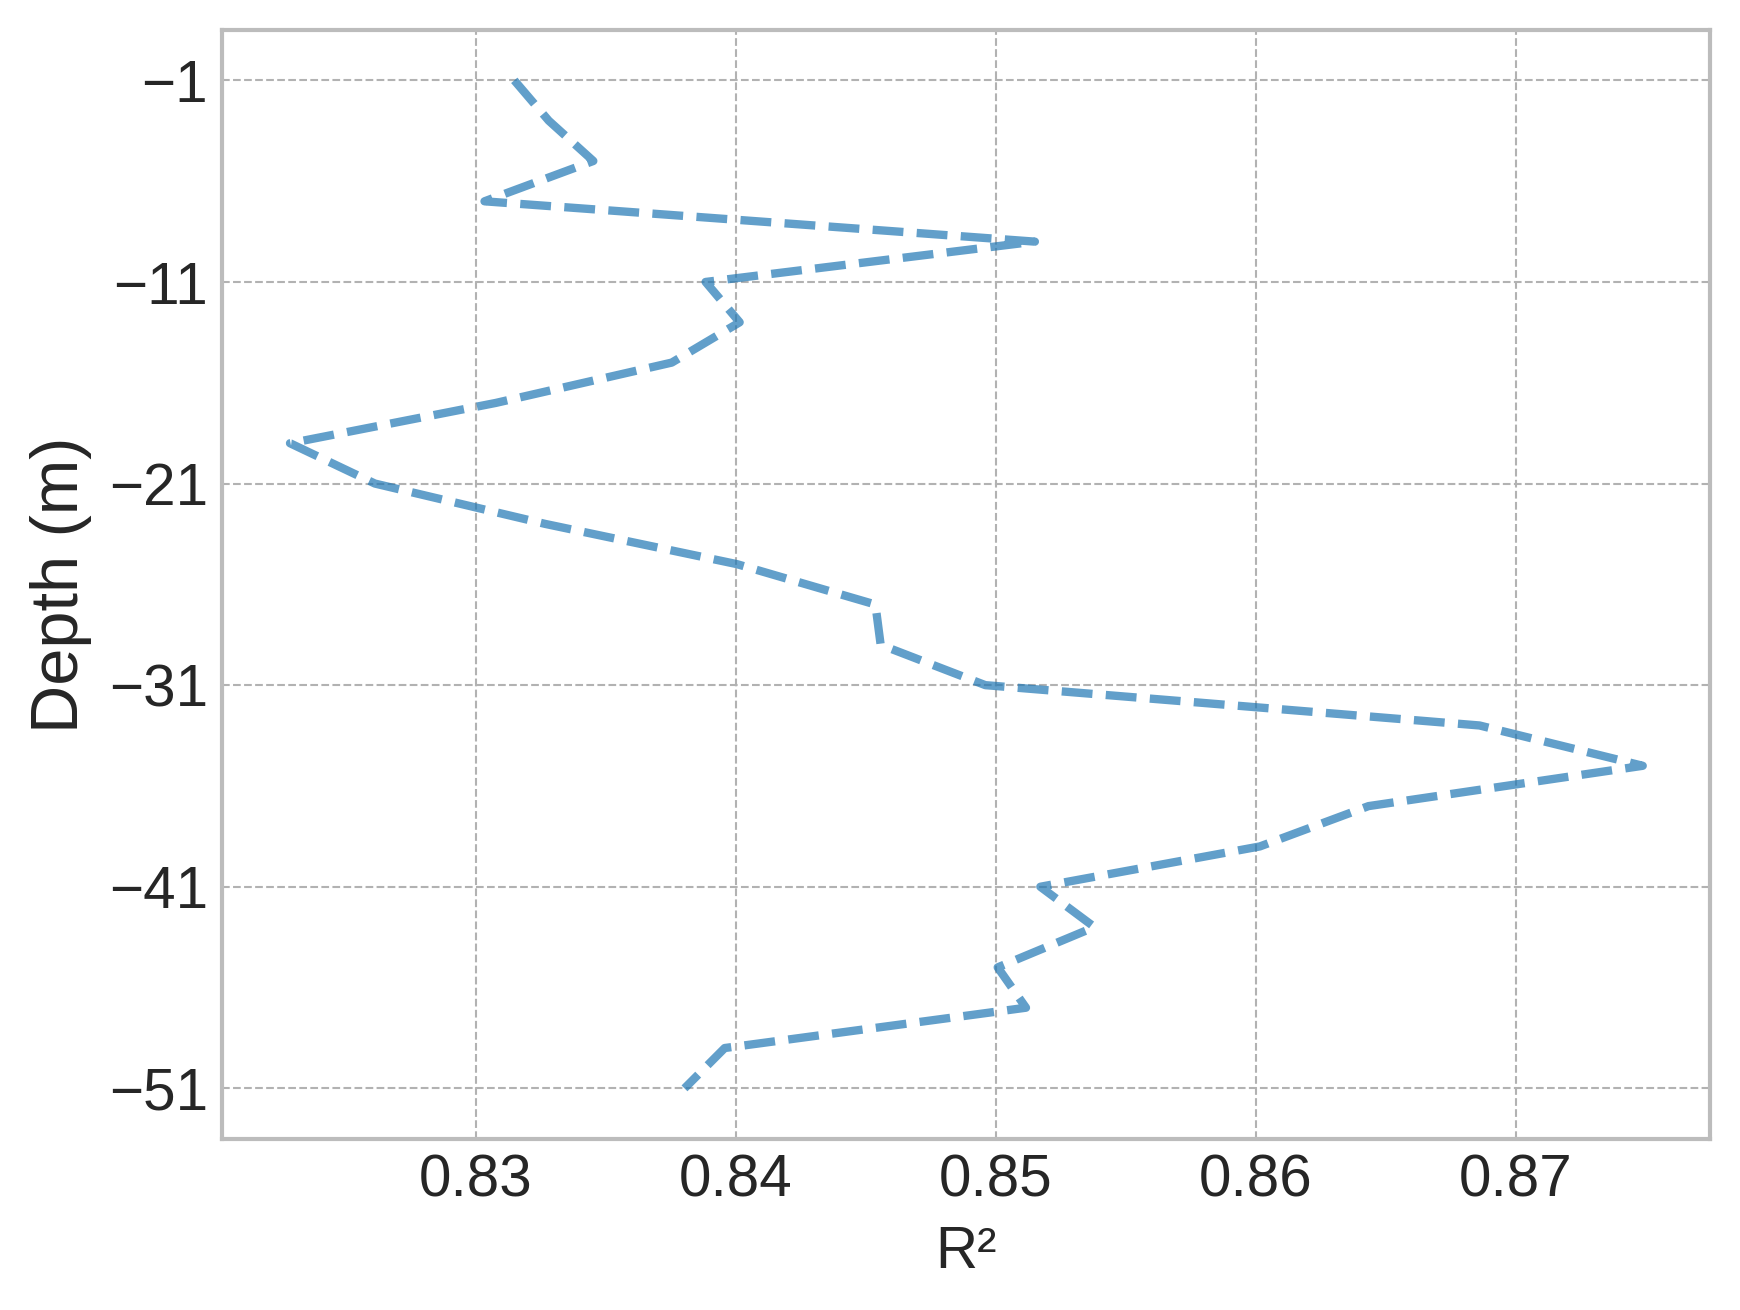

In [339]:
plot_r2_depth_profile(depth_metrics_df, setup,exports)

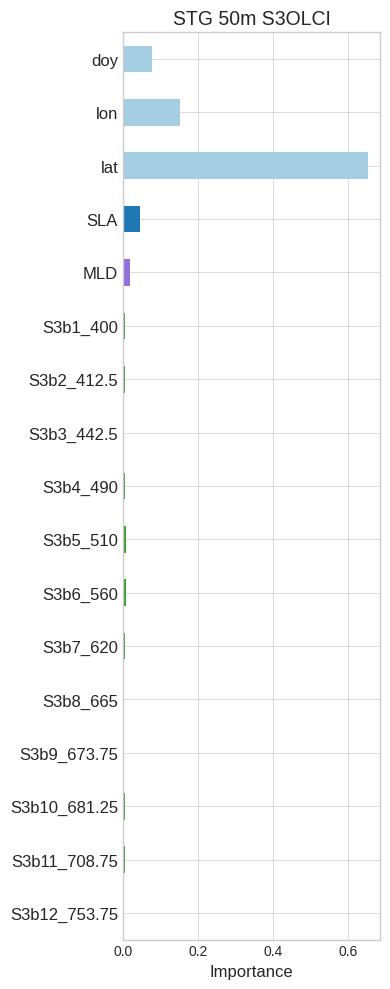

In [340]:
plot_feature_importance(model,x_train, setup, exports)

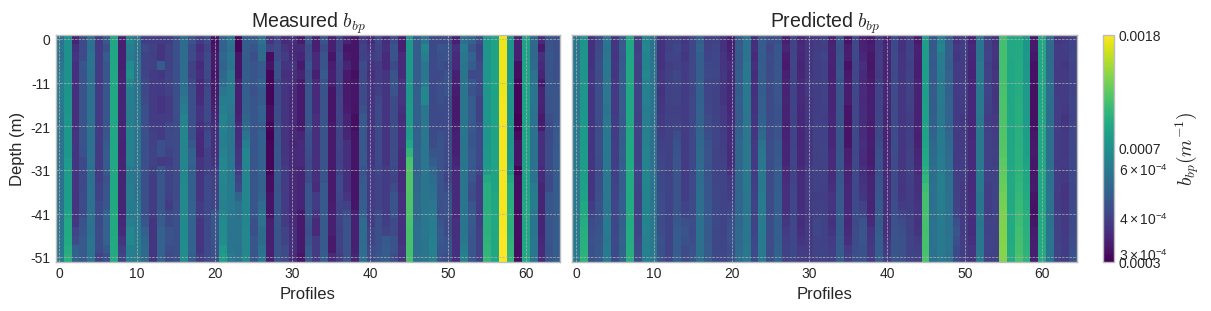

In [341]:
plot_bbp_profiles(y_test_bbp, y_pred_bbp, setup, exports)

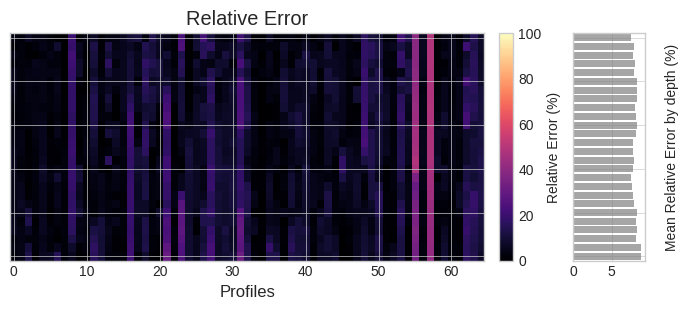

In [342]:
plot_relative_error(y_test_bbp, y_pred_bbp, setup, exports)

In [343]:
# Prepare validation
x_val, y_val_log= prepare_xy(validation, dataset_features, bbp_outputs)

In [344]:
y_pred_val_log = model.predict(x_val)

In [345]:
y_pred_val_bbp = log10_to_bbp(y_pred_val_log)
y_val_bbp = log10_to_bbp(y_val_log)

In [346]:
ov_metrics_val = overall_validation_metrics(y_val_bbp,y_pred_val_bbp)

In [347]:
ov_metrics_val

{'R2': 0.6317487957633635,
 'MSE': 1.4217608697531058e-09,
 'MAE': 3.0994611786221565e-05,
 'RMSE': 3.705188961463248e-05,
 'MAPD': np.float64(5.916548508049147)}

In [348]:
save_overall_validation_metrics(y_val_bbp, y_pred_val_bbp,setup, exports)

Saved overall validation metrics to: ../Results/STG/50/S3OLCI/Validation/Metrics/STG_50_S3OLCI_Val_overall_metrics.csv


In [349]:
depth_val_metrics_df = depth_val_metrics(y_val_bbp, y_pred_val_bbp, setup)

<Figure size 800x800 with 0 Axes>

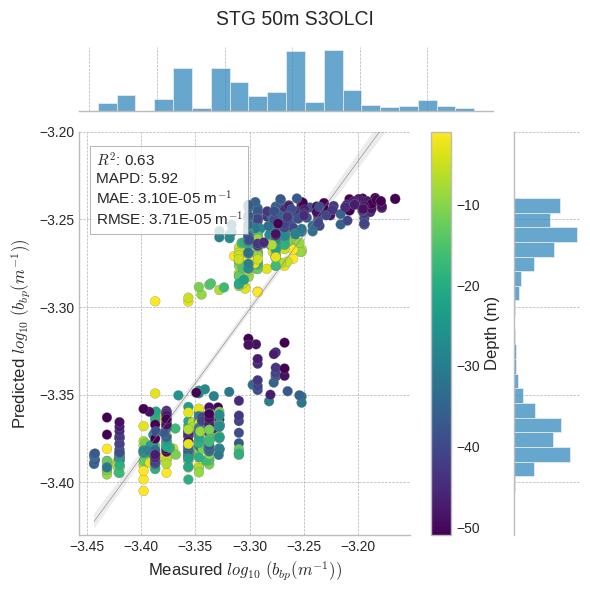

In [350]:
plot_validation_scatter(depth_val_metrics_df, y_val_log, y_pred_val_log, setup, exports)